Q1:  Implement Logistic Regression using the Pyro library referring [1] for guidance. Show both the mean prediction as well as standard deviation in the predictions over the 2d grid. Use NUTS MCMC sampling to sample the posterior. Take 1000 samples for posterior distribution and use 500 samples as burn/warm up. Use the below given dataset.
```python
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

X, y = make_moons(n_samples=100, noise=0.3, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2, random_state=42)
```

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch

In [2]:
try:
    import pyro
except ImportError:
    %pip install pyro-ppl
    import pyro

In [3]:
import pyro.distributions as dist

In [4]:
from pyro.infer import MCMC, NUTS, Predictive

In [5]:
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

X, y = make_moons(n_samples=100, noise=0.3, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2, random_state=42)

In [6]:
X_train = torch.tensor(X_train).float()
y_train = torch.tensor(y_train).float()
X_test = torch.tensor(X_test).float()
y_test = torch.tensor(y_test).float()
X_train.shape, y_train.shape,X_test.shape, y_test.shape

(torch.Size([80, 2]), torch.Size([80]), torch.Size([20, 2]), torch.Size([20]))

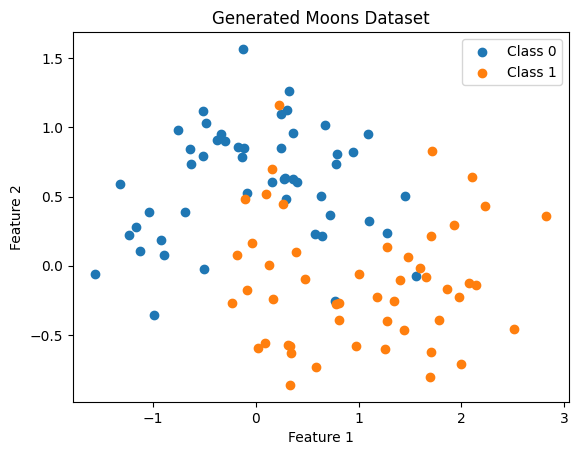

In [7]:
# Separate data points by class
class_0 = X[y == 0]
class_1 = X[y == 1]

# Create a scatter plot
plt.scatter(class_0[:, 0], class_0[:, 1], label="Class 0", marker='o')
plt.scatter(class_1[:, 0], class_1[:, 1], label="Class 1", marker='o')

plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title("Generated Moons Dataset")
plt.legend()
plt.show()

In [8]:
def logistic_model(X, y):
    # sample from prior
    w = pyro.sample(
      'w', dist.Normal(torch.zeros(X.shape[1]), torch.ones(X.shape[1]))
    )
    b = pyro.sample(
      'b', dist.Normal(torch.zeros(1), torch.ones(1))
    )
    with pyro.iarange('data', X.shape[0]):
        model_logits = torch.matmul(X, w) + b
        pyro.sample('obs', dist.Bernoulli(logits=model_logits), obs=y)

In [9]:
nuts_kernel = NUTS(logistic_model, adapt_step_size=True)
mcmc = MCMC(nuts_kernel, num_samples=1000, warmup_steps=500)
mcmc.run(X_train, y_train)

Sample: 100%|██████████| 1500/1500 [00:14, 100.04it/s, step size=5.46e-01, acc. prob=0.943]


In [10]:
posterior_samples = mcmc.get_samples()

/home/rishabh.mondal/miniconda3/envs/torch_env/lib/python3.11/site-packages/arviz/data/io_pyro.py:157: UserWarning: Could not get vectorized trace, log_likelihood group will be omitted. Check your model vectorization or set log_likelihood=False
  warnings.warn(


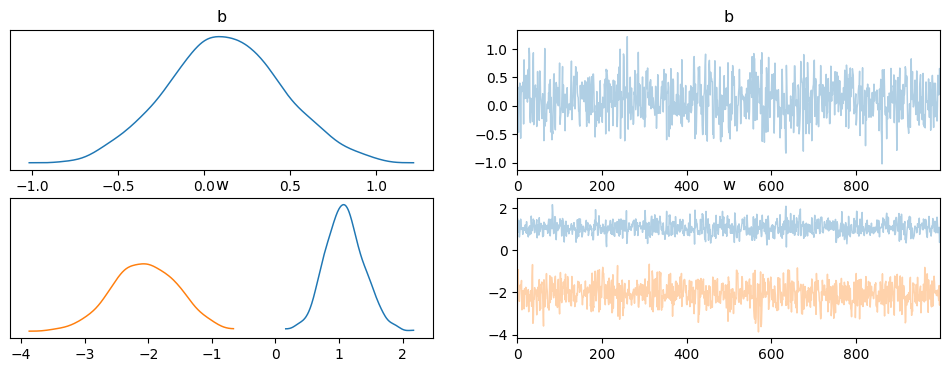

In [11]:
import arviz as az

idata = az.from_pyro(mcmc)
az.plot_trace(idata, compact=True);

/home/rishabh.mondal/miniconda3/envs/torch_env/lib/python3.11/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


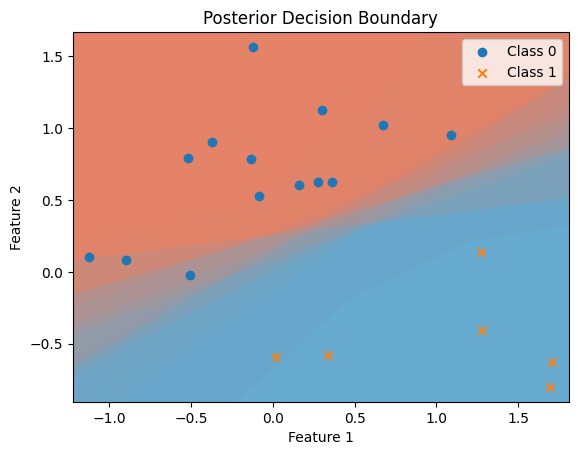

In [12]:
# Define a function to plot the decision boundary
def plot_decision_boundary(X, y, posterior_samples, title="Posterior Decision Boundary"):
    # Create a meshgrid of points for the entire feature space
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = torch.meshgrid(torch.linspace(x_min, x_max, 100), torch.linspace(y_min, y_max, 100))

    # Flatten the meshgrid for prediction
    grid = torch.cat((xx.reshape(-1, 1), yy.reshape(-1, 1)), dim=1)

    # Get the number of posterior samples
    num_samples = len(posterior_samples['w'])

    # Plot the posterior decision boundary for each sample
    for i in range(num_samples):
        w = posterior_samples['w'][i]
        b = posterior_samples['b'][i]

        # Calculate the logits and probabilities
        logits = torch.matmul(grid, w) + b
        probs = 1 / (1 + torch.exp(-logits))
        probs = probs.detach().numpy().reshape(xx.shape)

        # Plot the decision boundary
        plt.contourf(xx, yy, probs, levels=[0, 0.5, 1], alpha=0.2, cmap=plt.cm.RdBu)

    # Plot the data points
    plt.scatter(X[y == 0][:, 0], X[y == 0][:, 1], label="Class 0", marker='o')
    plt.scatter(X[y == 1][:, 0], X[y == 1][:, 1], label="Class 1", marker='x')

    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.title(title)
    plt.legend()
    plt.show()

# Assuming you have 'X_test' and 'y_test' as your test data and labels
plot_decision_boundary(X_test, y_test, posterior_samples)


In [13]:
X.shape, y.shape

((100, 2), (100,))